Rusty Bargain used car sales service is developing an app to attract new customers. In that app, you can quickly find out the market value of your car. You have access to historical data: technical specifications, trim versions, and prices. You need to build the model to determine the value. 

Rusty Bargain is interested in:

- the quality of the prediction;
- the speed of the prediction;
- the time required for training

## Data preparation

In [1]:
# Loading libraries
import pandas as pd
import numpy as np
from scipy import stats
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder, MaxAbsScaler, StandardScaler, OrdinalEncoder
from sklearn.metrics import mean_squared_error, make_scorer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_validate
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

In [2]:
# Loading data
df = pd.read_csv('car_data.csv')

In [3]:
# Basic information
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
1,24/03/2016 10:58,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,24/03/2016 00:00,0,66954,07/04/2016 01:46
2,14/03/2016 12:52,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,14/03/2016 00:00,0,90480,05/04/2016 12:47
3,17/03/2016 16:54,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,17/03/2016 00:00,0,91074,17/03/2016 17:40
4,31/03/2016 17:25,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,31/03/2016 00:00,0,60437,06/04/2016 10:17


### Preprocessing

In [5]:
%%time
# Changing to date time
df[['DateCrawled','DateCreated','LastSeen']] = df[['DateCrawled','DateCreated','LastSeen']].apply(pd.to_datetime)

Wall time: 1min


In [6]:
# Changing columns names for convenience
df.rename(columns = {'DateCrawled':'date_crawled','VehicleType':'vehicle_type',
                     'RegistrationYear':'registration_year','RegistrationMonth':'registration_month',
                     'FuelType':'fuel_type','NotRepaired':'repaired','DateCreated':'date_created',
                     'NumberOfPictures':'n_pictures','PostalCode':'postal_code','LastSeen':'last_seen'},
         inplace = True)
df.columns= df.columns.str.lower() #Changing col names to lower case letters
df.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,n_pictures,postal_code,last_seen
0,2016-03-24 11:52:00,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24,0,70435,2016-07-04 03:16:00
1,2016-03-24 10:58:00,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24,0,66954,2016-07-04 01:46:00


In [7]:
# Creating 'active time' feature
df['active_time(days)'] = (df['last_seen'] - df['date_created']).dt.days

In [8]:
# Creating 'car age' feature
df['car_age'] =   df['date_created'].dt.year -df['registration_year']

In [9]:
df.sample(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,n_pictures,postal_code,last_seen,active_time(days),car_age
177648,2016-09-03 21:36:00,1800,sedan,2002,manual,75,fiesta,150000,12,gasoline,ford,no,2016-09-03,0,10365,2016-03-13 01:45:00,-174,14
128742,2016-03-14 16:54:00,260,small,1995,manual,0,astra,150000,10,NaN,opel,NaN,2016-03-14,0,26810,2016-03-29 13:46:00,15,21


### Missing values

In [10]:
# Checking missing values
data_mis = df.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(df.isnull().sum()/len(df),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
repaired,71154,20.1
vehicle_type,37490,10.6
fuel_type,32895,9.3
gearbox,19833,5.6
model,19705,5.6
active_time(days),0,0.0
last_seen,0,0.0
postal_code,0,0.0
n_pictures,0,0.0
date_created,0,0.0


In [11]:
# Creating a copy of data frame before changes
raw_df = df.copy()

In [12]:
df = raw_df.copy()

In [13]:
# Dealing with missing values

# Transform 'repaired' missing values into 'unknown'
df['repaired'] = df['repaired'].fillna('unknown') 
# Droping 'price' missing values
df.drop(df[df['price'] == 0].index, inplace = True)
# Turning zeros in 'power' to mean value
df.loc[df['power'] == 0, 'power'] = round(df.power.mean())
# Droping missing values from 'model'
df = df.dropna(subset = ['model'])

In [14]:
# Checking missing values
data_mis = df.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(df.isnull().sum()/len(df),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
vehicle_type,28166,8.6
fuel_type,23551,7.2
gearbox,14270,4.4
brand,0,0.0
active_time(days),0,0.0
last_seen,0,0.0
postal_code,0,0.0
n_pictures,0,0.0
date_created,0,0.0
repaired,0,0.0


In [15]:
missing_cols = ['vehicle_type','fuel_type','gearbox']

In [16]:
# Imputer to treat missing values
imputer_cat = SimpleImputer(strategy='most_frequent')

In [17]:
# a function to treat missing values with mode
def impute(df, column, imputer):
    df[column] = imputer.fit_transform(
    df[column].values.reshape(-1,1))
    return df

In [18]:
# replacing missing values with the most common value
for col in missing_cols:
    df = impute(df,col,imputer_cat)

In [19]:
# # changing cetain columns to category type to lower memory usage
# df['gearbox'] = df['gearbox'].astype('category')
# df['fuel_type'] = df['fuel_type'].astype('category')
# df['repaired'] = df['repaired'].astype('category')

In [20]:
# Turning object type into category
for c in df.columns:
    col_type = df[c].dtype
    if col_type == 'object' or col_type.name == 'category':
        df[c] = df[c].astype('category')

In [21]:
# Checking missing values
data_mis = df.isnull().sum().to_frame('missing_values')
data_mis['%'] = round(df.isnull().sum()/len(df),3)*100
data_mis.sort_values(by='%', ascending=False)

,missing_values,%
date_crawled,0,0.0
price,0,0.0
active_time(days),0,0.0
last_seen,0,0.0
postal_code,0,0.0
n_pictures,0,0.0
date_created,0,0.0
repaired,0,0.0
brand,0,0.0
fuel_type,0,0.0


In [22]:
print(f"Portion of data removed in cleaning: {(raw_df.shape[0]-df.shape[0])/raw_df.shape[0]:.0%}")

Portion of data removed in cleaning: 8%


In [23]:
df.head(2)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,n_pictures,postal_code,last_seen,active_time(days),car_age
0,2016-03-24 11:52:00,480,sedan,1993,manual,111,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-07-04 03:16:00,102,23
2,2016-03-14 12:52:00,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown,2016-03-14,0,90480,2016-05-04 12:47:00,51,12


In [24]:
# Checking for duplicates
dup_number = df.duplicated().sum()
print(f"Number of duplicated rows: {dup_number} which is \
{round(dup_number/df.shape[0], 3):.1%} of the data")

Number of duplicated rows: 264 which is 0.1% of the data


In [25]:
# Getting rid of duplicates
df = df.drop_duplicates()

In [26]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 325812 entries, 0 to 354368
Data columns (total 18 columns):
 #   Column              Non-Null Count   Dtype         
---  ------              --------------   -----         
 0   date_crawled        325812 non-null  datetime64[ns]
 1   price               325812 non-null  int64         
 2   vehicle_type        325812 non-null  category      
 3   registration_year   325812 non-null  int64         
 4   gearbox             325812 non-null  category      
 5   power               325812 non-null  int64         
 6   model               325812 non-null  category      
 7   mileage             325812 non-null  int64         
 8   registration_month  325812 non-null  int64         
 9   fuel_type           325812 non-null  category      
 10  brand               325812 non-null  category      
 11  repaired            325812 non-null  category      
 12  date_created        325812 non-null  datetime64[ns]
 13  n_pictures          325812 no

**Memory usage dropped significantly!**

### Outliers

In [27]:
# Ploting histograms
def histo(data,col):    
    ax = plt.subplots()
    sns.set(rc={"figure.figsize":(7, 5)})
    sns.histplot(x=col, data=data)
    plt.title(f'{col} histogram', fontsize=14)

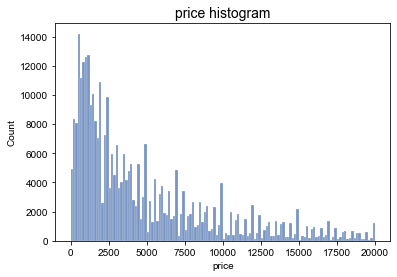

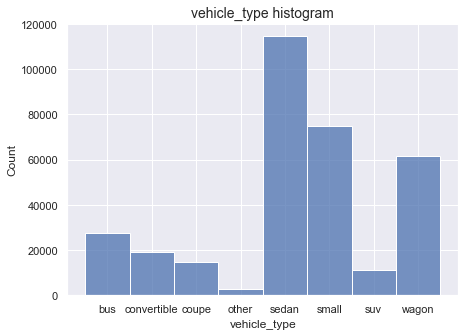

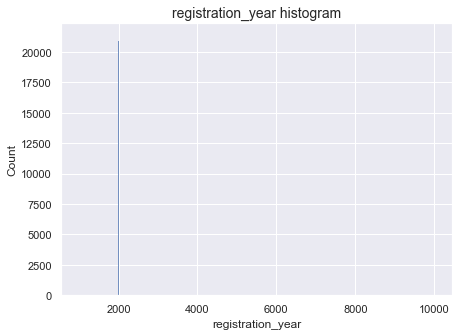

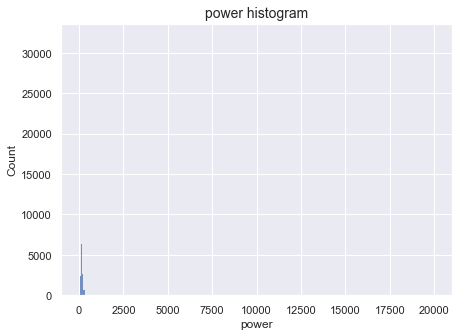

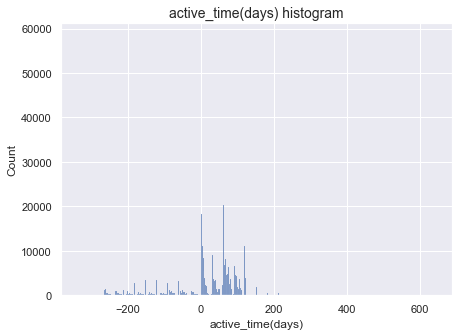

In [28]:
columns = ['price', 'vehicle_type', 'registration_year', 'power', 'active_time(days)']
for c in columns:
    histo(df,c)

In [29]:
# Getting rid of outliers in 'registration_year' and 'power' and 'active time' columns
df = df[(df['registration_year']>=1975) & (df['registration_year']<=2018) ]
df = df[(df['power'] > 0) & (df['power'] < 400)]
df = df[(df['active_time(days)'] > 0)]

In [30]:
df.head(1)

,date_crawled,price,vehicle_type,registration_year,gearbox,power,model,mileage,registration_month,fuel_type,brand,repaired,date_created,n_pictures,postal_code,last_seen,active_time(days),car_age
0,2016-03-24 11:52:00,480,sedan,1993,manual,111,golf,150000,0,petrol,volkswagen,unknown,2016-03-24,0,70435,2016-07-04 03:16:00,102,23


In [31]:
# Creating target and features
X = df.drop(['price','registration_year','registration_month','date_crawled','date_created','n_pictures','postal_code','last_seen'], axis=1)
y = df['price']

In [32]:
# OHE for categorical columns
X_ohe = pd.get_dummies(X, drop_first=True)
X_ohe.head()

,power,mileage,active_time(days),car_age,vehicle_type_convertible,vehicle_type_coupe,vehicle_type_other,vehicle_type_sedan,vehicle_type_small,vehicle_type_suv,...,brand_skoda,brand_smart,brand_subaru,brand_suzuki,brand_toyota,brand_trabant,brand_volkswagen,brand_volvo,repaired_unknown,repaired_yes
0,111,150000,102,23,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
2,163,125000,51,12,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0
4,69,90000,65,8,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
5,102,150000,61,21,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6,109,150000,121,12,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [33]:
# Transforming features into integers
enc = OrdinalEncoder()
enc.fit(X)
X_ordinal = enc.transform(X)

### summary
* Changed column names for convenience
* Added `active_time` and `car age` columns.
* Got rid of missing values.
* Got rid of duplicated rows.
* Got rid of outliers.
* Didn`t use unnecessary columns as features.
* One hot encoding for categorical columns.

## Model training

In [34]:
# Spliting the data into training set and test set: (with OTH)
features_train, features_test, target_train, target_test = train_test_split(
    X_ohe, y, test_size=0.2, random_state=12345)

In [35]:
print('Proportions out of original data')
print('---------------------------------')
print(f"TRAINING set:     {features_train.shape[0]/X.shape[0]:.0%}")
print(f"TEST set:         {features_test.shape[0]/X.shape[0]:.0%}")

Proportions out of original data
---------------------------------
TRAINING set:     80%
TEST set:         20%


In [36]:
# Spliting the data into training set and test set: (without OTH)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=12345)

In [37]:
print('Proportions out of original data')
print('---------------------------------')
print(f"TRAINING set:     {X_train.shape[0]/X.shape[0]:.0%}")
print(f"TEST set:         {X_test.shape[0]/X.shape[0]:.0%}")

Proportions out of original data
---------------------------------
TRAINING set:     80%
TEST set:         20%


In [38]:
# Spliting the data into training set and test set: (Ordinal)
X_train_ord, X_test_ord, y_train_ord, y_test_ord = train_test_split(
    X_ordinal, y, test_size=0.2, random_state=12345)

In [39]:
print('Proportions out of original data')
print('---------------------------------')
print(f"TRAINING set:     {X_train_ord.shape[0]/X.shape[0]:.0%}")
print(f"TEST set:         {X_test_ord.shape[0]/X.shape[0]:.0%}")

Proportions out of original data
---------------------------------
TRAINING set:     80%
TEST set:         20%


### Random forest training

In [40]:
%%time

rfr = RandomForestRegressor(random_state=12345)
params_grid = {"max_depth": [1, 3, 9],
              "n_estimators": [1, 3, 9]}

gs_rf = GridSearchCV(rfr, param_grid=params_grid, scoring='neg_root_mean_squared_error', cv=3)

gs_rf.fit(features_train, target_train)
print(f"best parameters: {gs_rf.best_params_}")
print(f"RMSE score: {-(gs_rf.best_score_):.3f}")

best parameters: {'max_depth': 9, 'n_estimators': 9}
RMSE score: 1983.498
Wall time: 1min 59s


### Decision tree training

In [41]:
%%time

dcr = DecisionTreeRegressor(random_state=12345)
params_grid = {"max_depth": [1, 3, 9]}

gs_dcr = GridSearchCV(dcr, param_grid=params_grid, scoring='neg_root_mean_squared_error', cv=3)

gs_dcr.fit(features_train, target_train)
print(f"best parameters: {gs_dcr.best_params_}")
print(f"RMSE score: {-(gs_dcr.best_score_):.3f}")

best parameters: {'max_depth': 9}
RMSE score: 2076.603
Wall time: 17 s


### LightGBM training

In [42]:
cat_cols = list(X.loc[:, X.dtypes == 'category'])
cat_cols

['vehicle_type', 'gearbox', 'model', 'fuel_type', 'brand', 'repaired']

In [43]:
cat_feature_list = np.where(X.dtypes != 'int64')[0]
cat_feature_list

array([0, 1, 3, 5, 6, 7], dtype=int64)

In [48]:
%%time

model = lgb.LGBMRegressor(random_state=12345)
params_grid = {'num_leaves': [7, 21, 50, 120],
              'max_depth': [-1, 3, 5]}

grid = GridSearchCV(model, param_grid=params_grid, scoring='neg_root_mean_squared_error', cv=3)
grid.fit(features_train, target_train)
lgbm_tuned = grid.best_estimator_

Wall time: 1min


In [49]:
print(f"Best parameters: {grid.best_params_}")
print(f"RMSE score: {-grid.best_score_:.3f}")

Best parameters: {'max_depth': -1, 'num_leaves': 120}
RMSE score: 1576.772


### CatBoostRegressor training

In [52]:
%%time
model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent',random_seed=12345)
params_grid = {'iterations': [100, 200,300],
        'learning_rate': [0.1,0.3,0.7],
        'depth': [3,8,20]}

search_results=model.grid_search(params_grid,features_train, y=target_train
                                      ,cv=3, verbose=False)

print(f"Best RMSE:{model.get_best_score()['learn']['RMSE']:.3f}")
print(f"Best parameters:{search_results['params']}")

Best RMSE:1421.022
Best parameters:{'depth': 8, 'iterations': 300, 'learning_rate': 0.3}
Wall time: 1min 5s


In [53]:
cv_results = pd.DataFrame(search_results["cv_results"])
cv_results.head()

,iterations,test-RMSE-mean,test-RMSE-std,train-RMSE-mean,train-RMSE-std
0,0,5022.272952,14.952590,5020.782255,6.747767
1,1,3934.938291,6.777927,3933.144790,18.923088
2,2,3209.631136,3.003971,3207.557249,22.644528
3,3,2755.211084,4.255837,2751.847674,24.285607
4,4,2469.008491,14.705122,2465.206107,7.476492


### Sanity check with linear regression

In [54]:
%%time

lr = LinearRegression()
scores = cross_validate(lr, features_train, target_train, cv=3, scoring='neg_root_mean_squared_error')
print(f"Fit time: {scores['fit_time'].sum():.3f}")
print(f"Best RMSE score: {-scores['test_score'].max():.3f}")

Fit time: 8.680
Best RMSE score: 2579.841
Wall time: 9.25 s


### Conclusions

* The scaled data and the original data have the same results.
* The best model is the CatBoostRegressor with `'depth': 8`, `'iterations': 300`, `'learning_rate': 0.3` and `RMSE: 1397`.
* The sanity check RMSE score is 2579 which is lower than the random forest and decision tree models.
* I'm sure that I could tune the hyperparameters more to lower the loss function score but it would take a lot of time for each train.

## Model analysis

### Catboost

In [65]:
%%time

cat_model = CatBoostRegressor(loss_function='RMSE', logging_level='Silent', iterations=300,
                              depth=8, learning_rate=0.3, random_seed=12345, cat_features=cat_cols)
cat_model.fit(X_train, y_train)

Wall time: 42.5 s


In [66]:
%%time
y_pred = cat_model.predict(X_test)
RMSE = mean_squared_error(y_pred, y_test, squared=False)
print(f"RMSE: {RMSE:.3f}")

RMSE: 1541.685
Wall time: 53 ms


Text(0.5, 0, 'CatBoost Feature Importance')

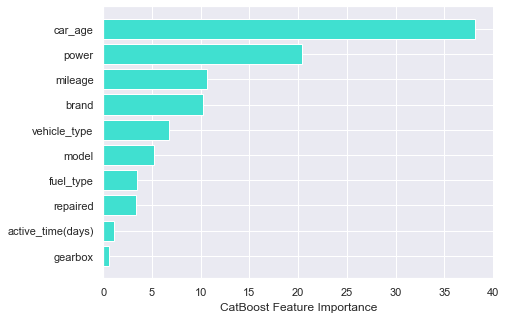

In [67]:
# Checking feature importance
sorted_feature_importance = cat_model.feature_importances_.argsort()
plt.barh(X.columns[sorted_feature_importance], 
        cat_model.feature_importances_[sorted_feature_importance], 
        color='turquoise')
plt.xlabel("CatBoost Feature Importance")

In [68]:
print(f'The median of the car prices is: {y.median()}')

The median of the car prices is: 3000.0


## Final conclusions
* The best model is the cat boost regressor with RMSE of 1541 on the test set.
* the RMSE is half the median of the car prices, which is a lot.
* The results could be improved with deeper hyperparameters tuning but it will take much more time to train the models.
* For this results it will take (on my system) 8 seconds to train the catboost model.